In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
import sys
sys.path.append('../src')

In [4]:
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import seaborn as sns
import torch
import pandas as pd
import spaceoracle
from spaceoracle import SpaceOracle

In [5]:
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import r2_score

In [6]:
adata_train = sc.read_h5ad('.cache/adata_train.h5ad')
adata_train

AnnData object with n_obs × n_vars = 11567 × 5013
    obs: 'cluster', 'rctd_cluster', 'rctd_celltypes'
    uns: 'log1p'
    obsm: 'X_spatial', 'rctd_results', 'spatial'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [7]:
from spaceoracle.models.parallel_estimators import SpatialCellularProgramsEstimator

In [8]:
from spaceoracle.models.pixel_attention import CellularNicheNetwork

In [9]:
from spaceoracle.tools.utils import search

In [ ]:
CellularNicheNetwork(n_modulators=1, anchors=torch.tensor([1, 0.5]), spatial_dim=2, n_clusters=3)

In [118]:
from torch import nn

In [137]:
adata_train = adata_train[adata_train.obs.rctd_cluster.isin([0, 1, 2])]

In [191]:
estimator = SpatialCellularProgramsEstimator(
    adata=adata_train,
    target_gene='Mt1',
)

In [192]:
%%time

estimator.fit(num_epochs=250, threshold_lambda=1e-4, learning_rate=5e-4)

Fitting Mt1 with 264 modulators
	65 Transcription Factors
	27 Ligand-Receptor Pairs
	172 TranscriptionFactor-Ligand Pairs
0: 0.2637 | 0.2385
1: 0.4754 | 0.4237
2: 0.4827 | 0.4024
CPU times: user 3min 16s, sys: 31.2 s, total: 3min 48s
Wall time: 12min 25s


In [193]:
df = estimator.betadata

In [194]:
estimator.betadata.to_parquet(f'./models/{estimator.target_gene}_betadata.parquet')

In [195]:
# df = estimator.betadata
# betas = torch.from_numpy(
#     df[['beta0']+['beta_'+i for i in estimator.modulators]].values).float()

# inputs_x = torch.from_numpy(
#     estimator.train_df.drop(
#         columns=estimator.target_gene).values).float()

In [196]:
# plt.rcParams['figure.figsize'] = (25, 3)
# plt.rcParams['figure.dpi'] = 120

# hmap = df[[
#         'beta_'+i for i in estimator.modulators if '#' not in i and '$' not in i]+[
#             'rctd_celltypes']].groupby('rctd_celltypes').mean().abs()>0
# sns.heatmap(
#     hmap.loc[:, (hmap.sum(0) > 0)],
#     square=True,
#     cbar=False,
#     linewidths=0.5,
#     linecolor='black',
#     xticklabels=True,
#     yticklabels=True,
#     cmap='Reds'
# )
# plt.title(f'Modulators for {estimator.target_gene}', fontsize=15)
# plt.tight_layout()
# plt.show()

# plt.rcParams['figure.figsize'] = (25, 5)
# hmap = df[[
#         'beta_'+i for i in estimator.modulators if '$' in i]+[
#             'rctd_celltypes']].groupby('rctd_celltypes').mean().abs()>0
# sns.heatmap(
#     hmap.loc[:, (hmap.sum(0) > 0)],
#     square=True,
#     cbar=False,
#     linewidths=0.5,
#     linecolor='black',
#     xticklabels=True,
#     yticklabels=True,
#     cmap='Reds'
# )
# plt.title(f'Modulators for {estimator.target_gene}', fontsize=15)
# plt.tight_layout()
# plt.show()
# hmap = df[[
#         'beta_'+i for i in estimator.modulators if '#' in i]+[
#             'rctd_celltypes']].groupby('rctd_celltypes').mean().abs()>0
# sns.heatmap(
#     hmap.loc[:, (hmap.sum(0) > 0)],
#     square=True,
#     cbar=False,
#     linewidths=0.5,
#     linecolor='black',
#     xticklabels=True,
#     yticklabels=True,
#     cmap='Reds'
# )

# plt.title(f'Modulators for {estimator.target_gene}', fontsize=15)
# plt.tight_layout()
# plt.show()

In [197]:
# y_pred = CellularNicheNetwork.predict_y(inputs_x, betas)

# r2_score(
#     estimator.train_df[estimator.target_gene], 
#     y_pred.cpu().numpy()
# )

In [198]:
cmaps = dict(zip(range(7), ['rainbow', 'hot', 'cool_r', 'spring', 'viridis', 'PuRd', 'Reds']))


In [199]:
from spaceoracle.oracles import SpaceOracle
from spaceoracle.tools.utils import min_max_df

so = SpaceOracle(adata=adata_train)
beta_dict = {estimator.target_gene: so._get_betas(estimator.target_gene)}

gex_df = min_max_df(estimator.adata.to_df(layer=estimator.layer))
beta_dict = so._get_wbetas_dict(beta_dict, gex_df, n_jobs=1)
wbetas = beta_dict[estimator.target_gene].wbetas


# reformat betas so it's the same as when plot method was written
xy = pd.DataFrame(
    adata_train.obsm['spatial'], index=adata_train.obs.index, columns=['x', 'y'])

df = wbetas \
        .join(adata_train.obs) \
        .join(xy) \
        .join(gex_df)

df

  0%|          | 0/1 [00:00<?, ?it/s]

beta_Angptl2  beta_Angptl4  beta_Arid5a  beta_Atf3  \
AAAAAACGGTAGAT      0.043941           0.0     0.000006   0.034838   
AAAAACCGTCAGAC      0.031901           0.0    -0.000010   0.038653   
AAAAACGCTCCGAC      0.032560           0.0    -0.000007   0.036218   
AAAAAGCACGTGTT      0.025816           0.0     0.000001   0.033525   
AAAAAGCGGCGCAC     -0.001865           0.0    -0.000013   0.048257   
...                      ...           ...          ...        ...   
TTTTTTATAATACC      0.045117           0.0     0.000006   0.028419   
TTTTTTGGGCTGGT     -0.013888           0.0    -0.000024   0.048649   
TTTTTTGTACCCAC     -0.009042           0.0    -0.000043   0.055688   
TTTTTTGTACGATT      0.028587           0.0    -0.000003   0.036888   
TTTTTTTTGCTTTA      0.046545           0.0     0.000007   0.034731   

                  beta_Bach1  beta_Bach2  beta_Bcl11a  beta_Bclaf1  \
AAAAAACGGTAGAT -1.006331e-05    0.075309    -0.000024    -0.000002   
AAAAACCGTCAGAC -1.672223e-05    0.101590    -0.000047     0.000009   
AAAAACGCTCCGAC -1.918100e-05    0.129776    -0.000048    -0.000002   
AAAAAGCACGTGTT -2.167721e-05    0.074626    -0.000057     0.000003   
AAAAAGCGGCGCAC  6.542004e-07    0.295235    -0.000040     0.000020   
...                      ...         ...          ...          ...   
TTTTTTATAATACC -1.355055e-05    0.104878    -0.000033    -0.000013   
TTTTTTGGGCTGGT  4.185162e-06    0.364855    -0.000074     0.000037   
TTTTTTGTACCCAC -7.377568e-06    0.261003    -0.000074     0.000042   
TTTTTTGTACGATT -6.016152e-06    0.162467    -0.000021     0.000011   
TTTTTTTTGCTTTA -1.160481e-05    0.066924    -0.000032    -0.000004   

                beta_Bhlhe41  beta_Brca1  ...    Zswim1    Zswim3    Zswim4  \
AAAAAACGGTAGAT     -0.011837   -0.032472  ...  0.097589  0.421042  0.176841   
AAAAACCGTCAGAC     -0.010600   -0.023073  ...  0.493399  0.274746  0.176841   
AAAAACGCTCCGAC     -0.021123   -0.013098  ...  0.493399  0.274746  0.188951   
AAAAAGCACGTGTT     -0.015684   -0.019941  ...  0.682703  0.274746  0.000000   
AAAAAGCGGCGCAC     -0.060744    0.006154  ...  0.000000  0.535861  0.000000   
...                      ...         ...  ...       ...       ...       ...   
TTTTTTATAATACC     -0.015248   -0.033407  ...  0.379158  0.182942  0.000000   
TTTTTTGGGCTGGT     -0.061809    0.015671  ...  0.000000  0.389565  0.365792   
TTTTTTGTACCCAC     -0.029361   -0.003450  ...  0.121475  0.274746  0.176841   
TTTTTTGTACGATT     -0.018255   -0.048827  ...  0.120031  0.274746  0.000000   
TTTTTTTTGCTTTA     -0.011249   -0.031454  ...  0.618684  0.175016  0.179181   

                  Zswim6    Zswim9      Zup1      Zw10    Zwilch      Zxdc  \
AAAAAACGGTAGAT  0.131493  0.000000  0.472964  0.564513  0.688471  0.512763   
AAAAACCGTCAGAC  0.586356  0.397738  0.223781  0.277076  0.394960  0.227259   
AAAAACGCTCCGAC  0.314296  0.177184  0.310542  0.415657  0.276316  0.520555   
AAAAAGCACGTGTT  0.313466  0.177184  0.268726  0.641424  0.591450  0.432878   
AAAAAGCGGCGCAC  0.202773  0.191453  0.408275  0.295863  0.704006  0.512995   
...                  ...       ...       ...       ...       ...       ...   
TTTTTTATAATACC  0.292472  0.342622  0.401811  0.494195  0.580476  0.513694   
TTTTTTGGGCTGGT  0.280179  0.191453  0.429524  0.326576  0.641225  0.516638   
TTTTTTGTACCCAC  0.206385  0.000000  0.579687  0.561819  0.622101  0.439503   
TTTTTTGTACGATT  0.178278  0.165439  0.262309  0.260203  0.563994  0.442145   
TTTTTTTTGCTTTA  0.363042  0.165439  0.450215  0.503458  0.470099  0.464827   

                   Zzef1  
AAAAAACGGTAGAT  0.480498  
AAAAACCGTCAGAC  0.555024  
AAAAACGCTCCGAC  0.443189  
AAAAAGCACGTGTT  0.553478  
AAAAAGCGGCGCAC  0.533129  
...                  ...  
TTTTTTATAATACC  0.429175  
TTTTTTGGGCTGGT  0.736519  
TTTTTTGTACCCAC  0.638128  
TTTTTTGTACGATT  0.544778  
TTTTTTTTGCTTTA  0.423503  

[10562 rows x 5119 columns]

In [200]:
markers = ['o', 'X', '<', '^', 'v', 'D', '>']
cmaps = dict(zip(range(7), ['rainbow', 'cool', 'RdYlGn_r', 'spring_r', '', 'PuRd', 'Reds']))
cell_map = dict(zip(df['rctd_cluster'], df['rctd_celltypes']))

def plot(plot_for, clusters=[0, 1, 2], with_expr=False, size=25, linewidth=0.5, alpha=1, edgecolor='black', dpi=100, figsize=(11, 9), fig=None, axes=None):

    if fig is None or axes is None:
        fig, (ax, cax) = plt.subplots(1, 2, dpi=dpi, figsize=figsize, gridspec_kw={'width_ratios': [4, 0.5]})
    else:
        ax, cax = axes

    # Get cluster-specific min/max for individual colorbar scales
    norms = {}
    for i in clusters:
        cluster_data = df[df.rctd_cluster==i][plot_for]
        vmin = cluster_data.min()
        vmax = cluster_data.max()
        norms[i] = plt.Normalize(vmin=vmin, vmax=vmax)

    for i in clusters:
        betas_df = df[df.rctd_cluster==i]
        missing_columns = list(set(estimator.train_df.columns) - set(betas_df.columns))
        betas_df = betas_df.join(estimator.train_df[missing_columns])

        if with_expr:
            betas_df[plot_for] = betas_df[plot_for]*betas_df[plot_for.replace('beta_', '')]

        sns.scatterplot(
            data=betas_df,
            x='x', 
            y='y',
            hue=plot_for,
            palette=cmaps[i],
            s=size,
            alpha=alpha,
            linewidth=linewidth,
            edgecolor=edgecolor,
            legend=False,
            style='rctd_celltypes',
            markers=markers,
            ax=ax
        )
    ax.axis('off')

    cbar_width = 0.15  # Width of each colorbar
    cbar_height = 0.8 / len(cmaps)  # Height of each colorbar
    for i, cmap_name in cmaps.items():
        if i not in [0, 1, 2]:
            continue
        cmap = plt.get_cmap(cmap_name)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norms[i])
        sm.set_array([])
        cax_i = cax.inset_axes([0.2, 0.95 - (i+1)*cbar_height*2.5, cbar_width, cbar_height*1.5])
        cbar = fig.colorbar(sm, cax=cax_i, orientation='vertical')
        cbar.ax.tick_params(labelsize=9)  # Reduce tick label size
        cbar.ax.set_title(f'{cell_map[i]}', fontsize=12, pad=8)  # Reduce title size and padding

    cax.set_ylabel(plot_for, fontsize=8)
    cax.axis('off')

    unique_styles = sorted(set(df['rctd_celltypes']))
    style_handles = [plt.Line2D([0], [0], marker=m, color='w', markerfacecolor='gray', 
                    markersize=10, linestyle='None', alpha=1) 
                    for m in markers][:len(unique_styles)]
    ax.legend(style_handles, unique_styles, ncol=1,
        title='Cell types', loc='lower left',  
        frameon=False)

    ax.set_title(f'{plot_for} > {estimator.target_gene}', fontsize=15)
    
    return ax

In [201]:
df.columns

Index(['beta_Angptl2', 'beta_Angptl4', 'beta_Arid5a', 'beta_Atf3',
       'beta_Bach1', 'beta_Bach2', 'beta_Bcl11a', 'beta_Bclaf1',
       'beta_Bhlhe41', 'beta_Brca1',
       ...
       'Zswim1', 'Zswim3', 'Zswim4', 'Zswim6', 'Zswim9', 'Zup1', 'Zw10',
       'Zwilch', 'Zxdc', 'Zzef1'],
      dtype='object', length=5119)

<Axes: title={'center': 'beta_Il2ra > Mt1'}, xlabel='x', ylabel='y'>

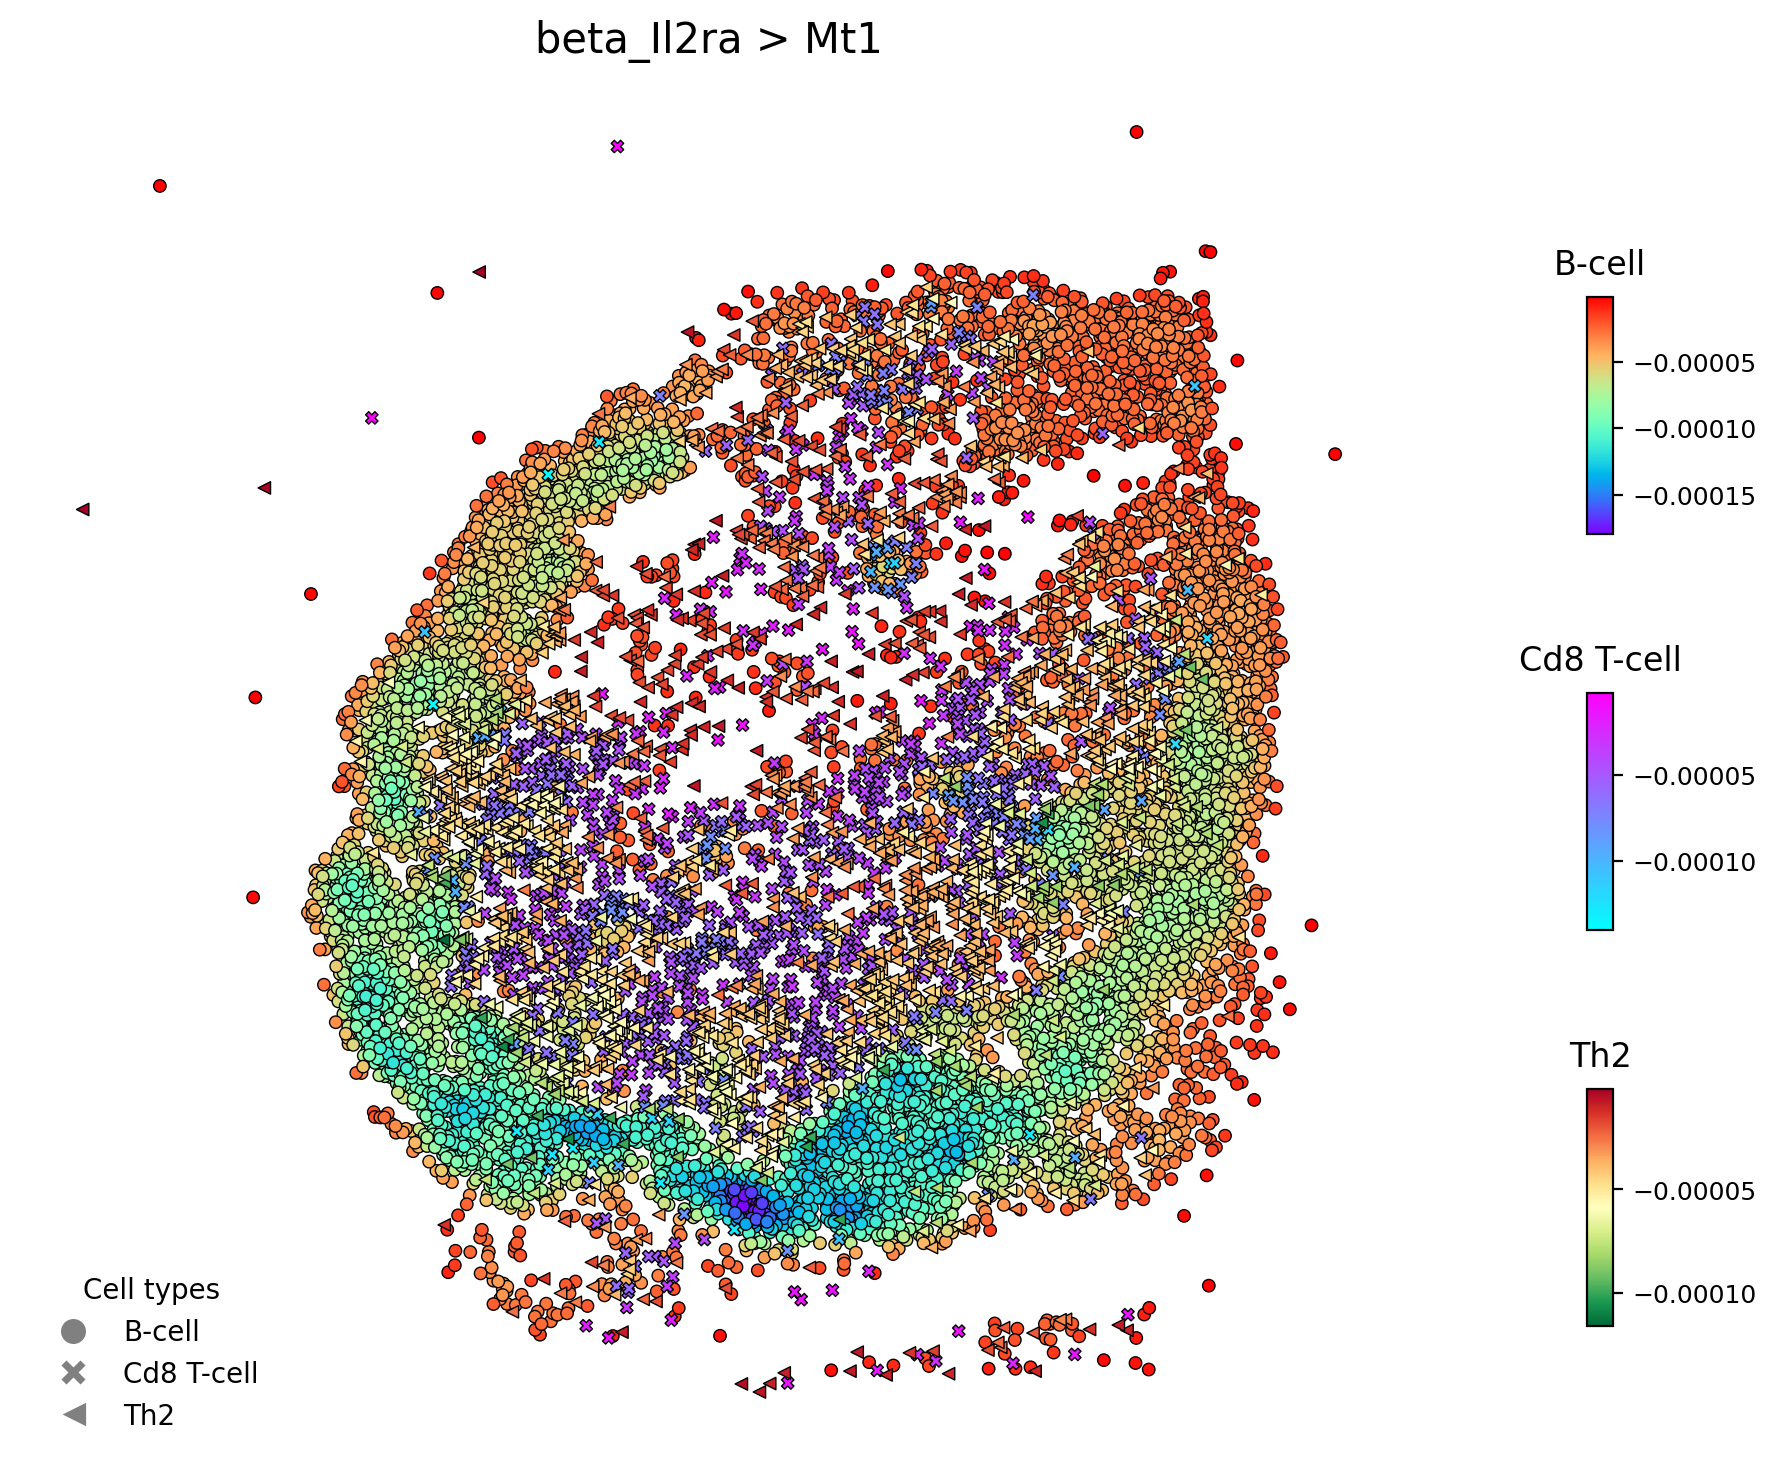

In [207]:
plot('beta_Il2ra', dpi=100, size=20, with_expr=False)

<Axes: title={'center': 'beta_Pax5 > Cd74'}, xlabel='x', ylabel='y'>

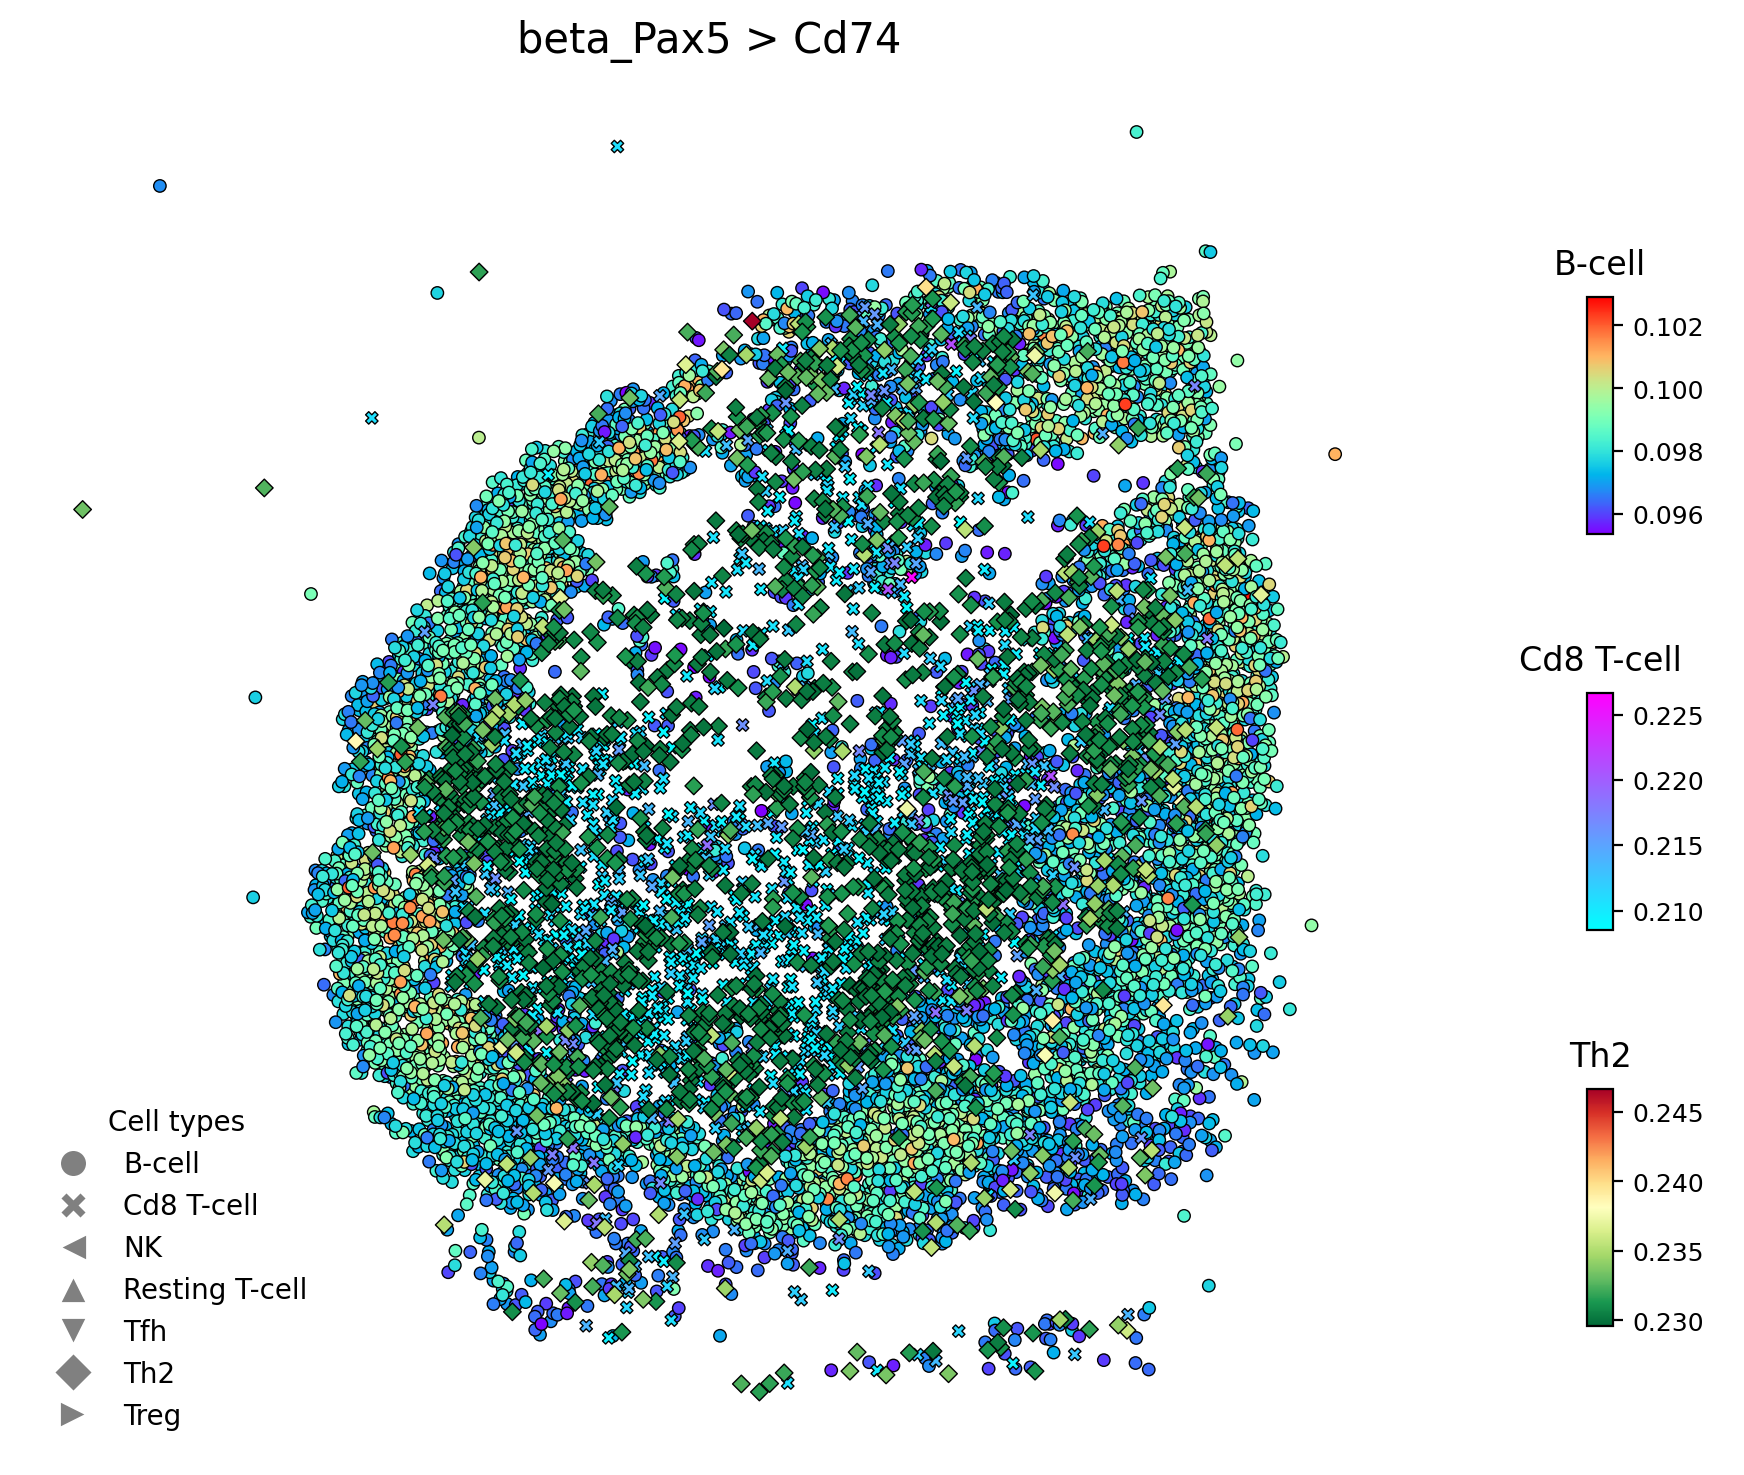

In [97]:
plot('beta_Pax5', dpi=100, size=20, with_expr=True)

<Axes: title={'center': 'Il2ra > Cd74'}, xlabel='x', ylabel='y'>

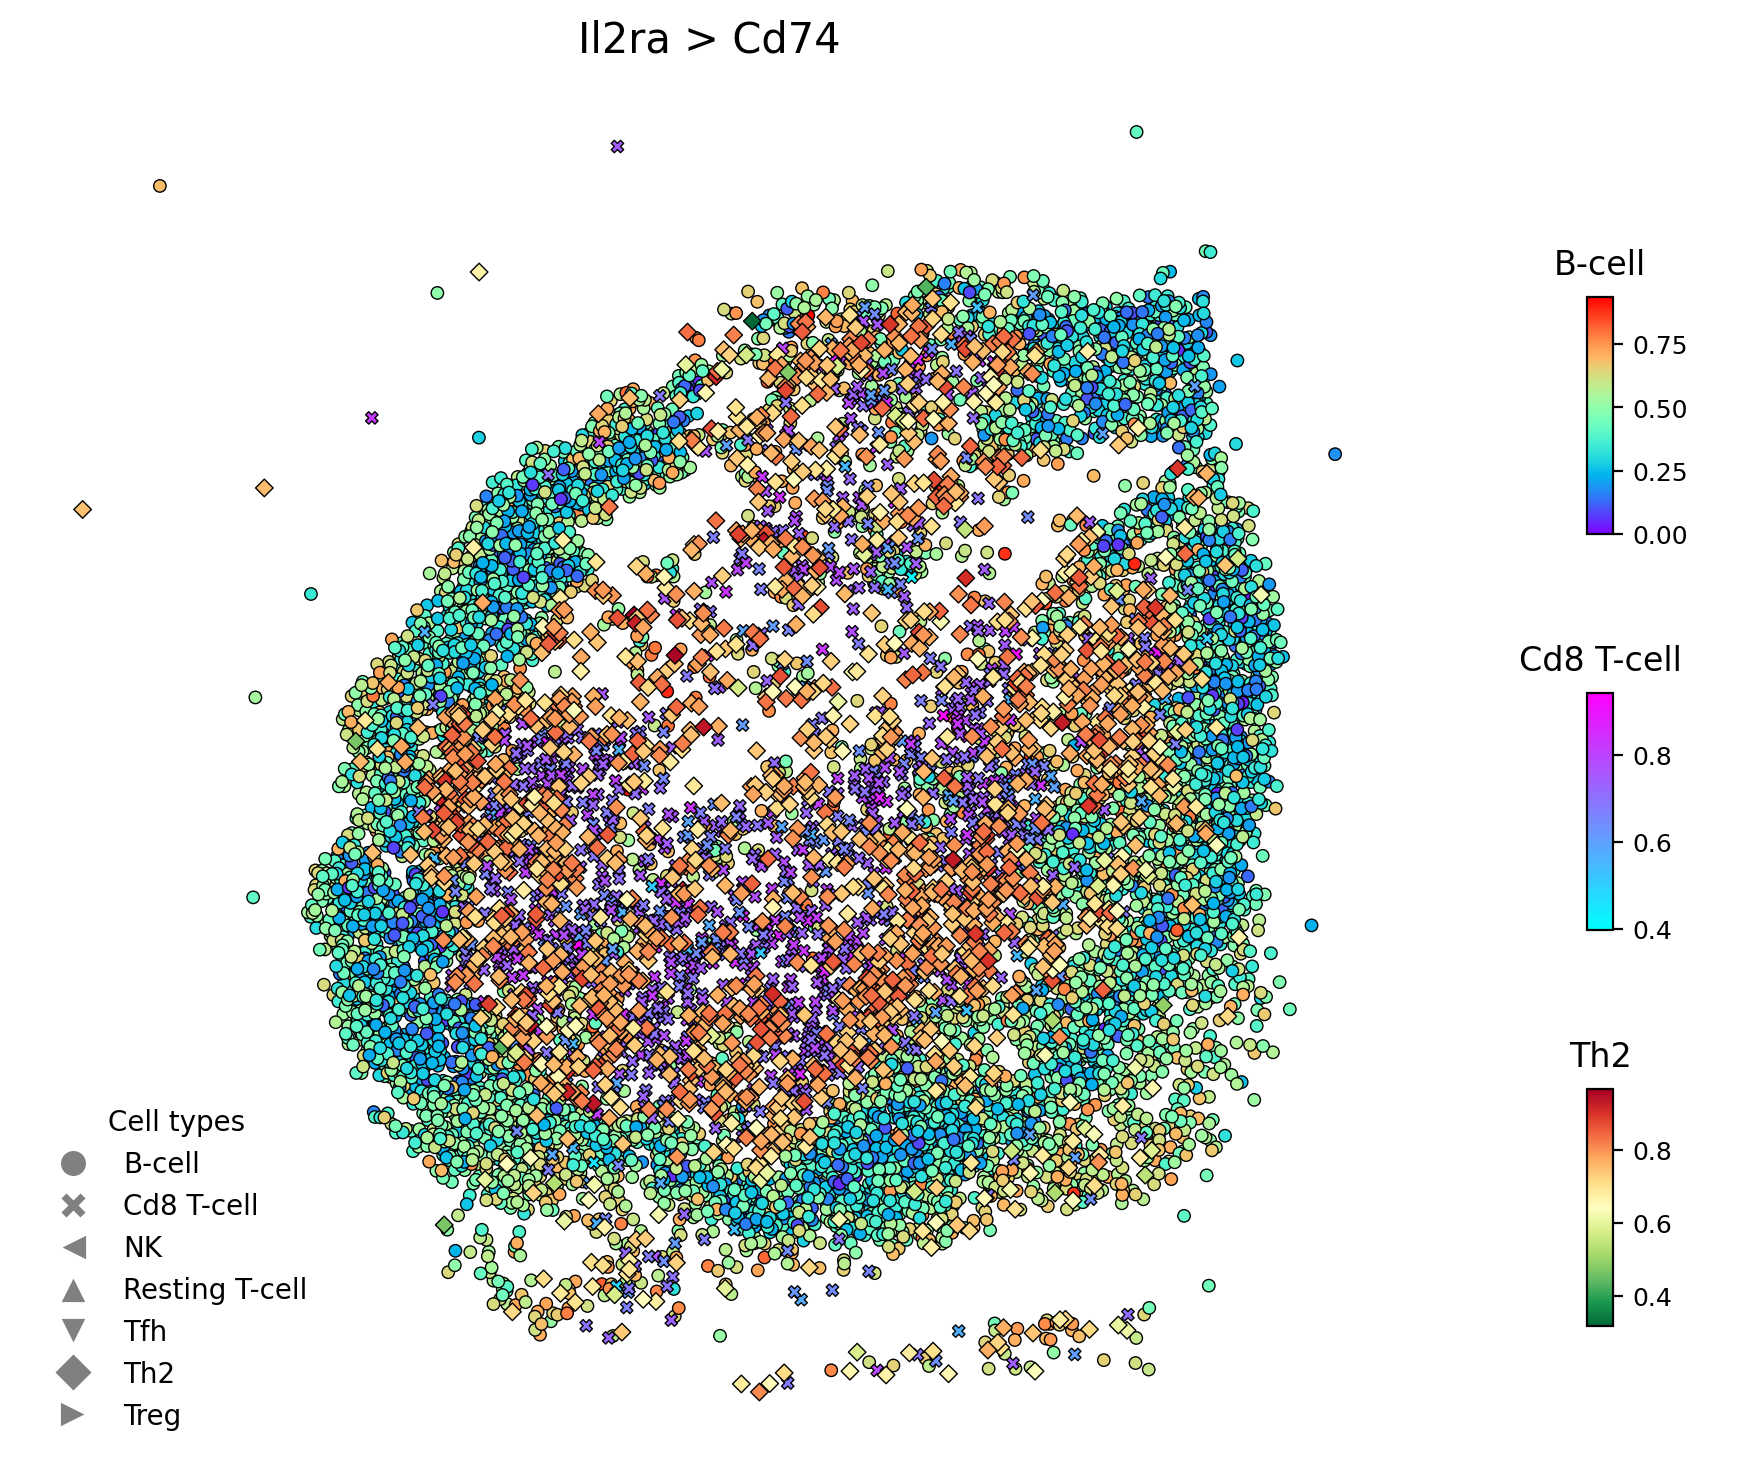

In [73]:
plot('Il2ra', dpi=100, size=20)

<Axes: title={'center': 'beta_Il2ra > Cd74'}, xlabel='x', ylabel='y'>

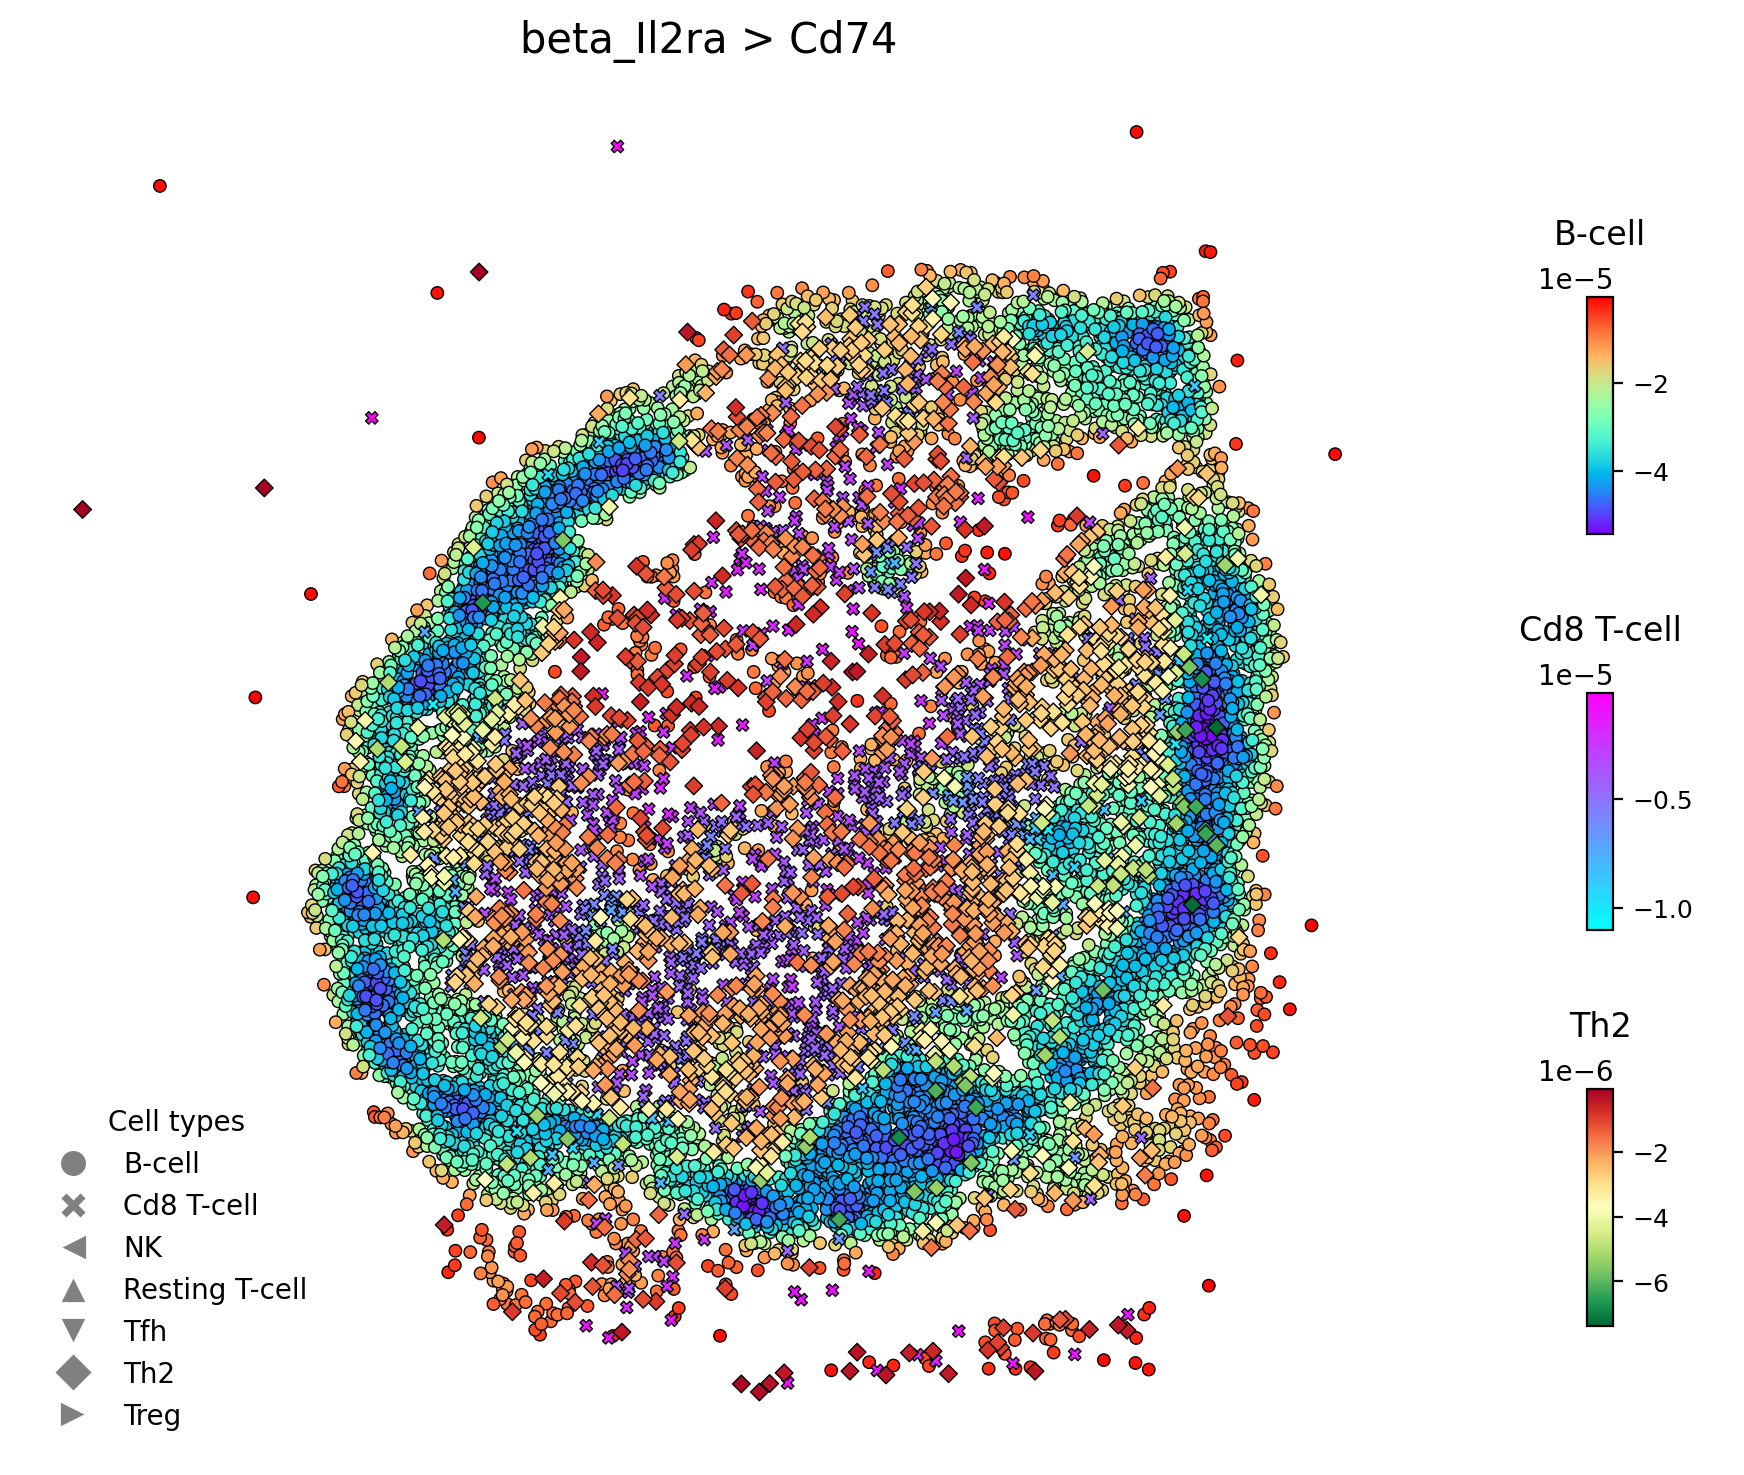

In [74]:
plot('beta_Il2ra', dpi=100, size=20)

ValueError: Could not interpret value `beta_Il2#Egr2` for `hue`. An entry with this name does not appear in `data`.

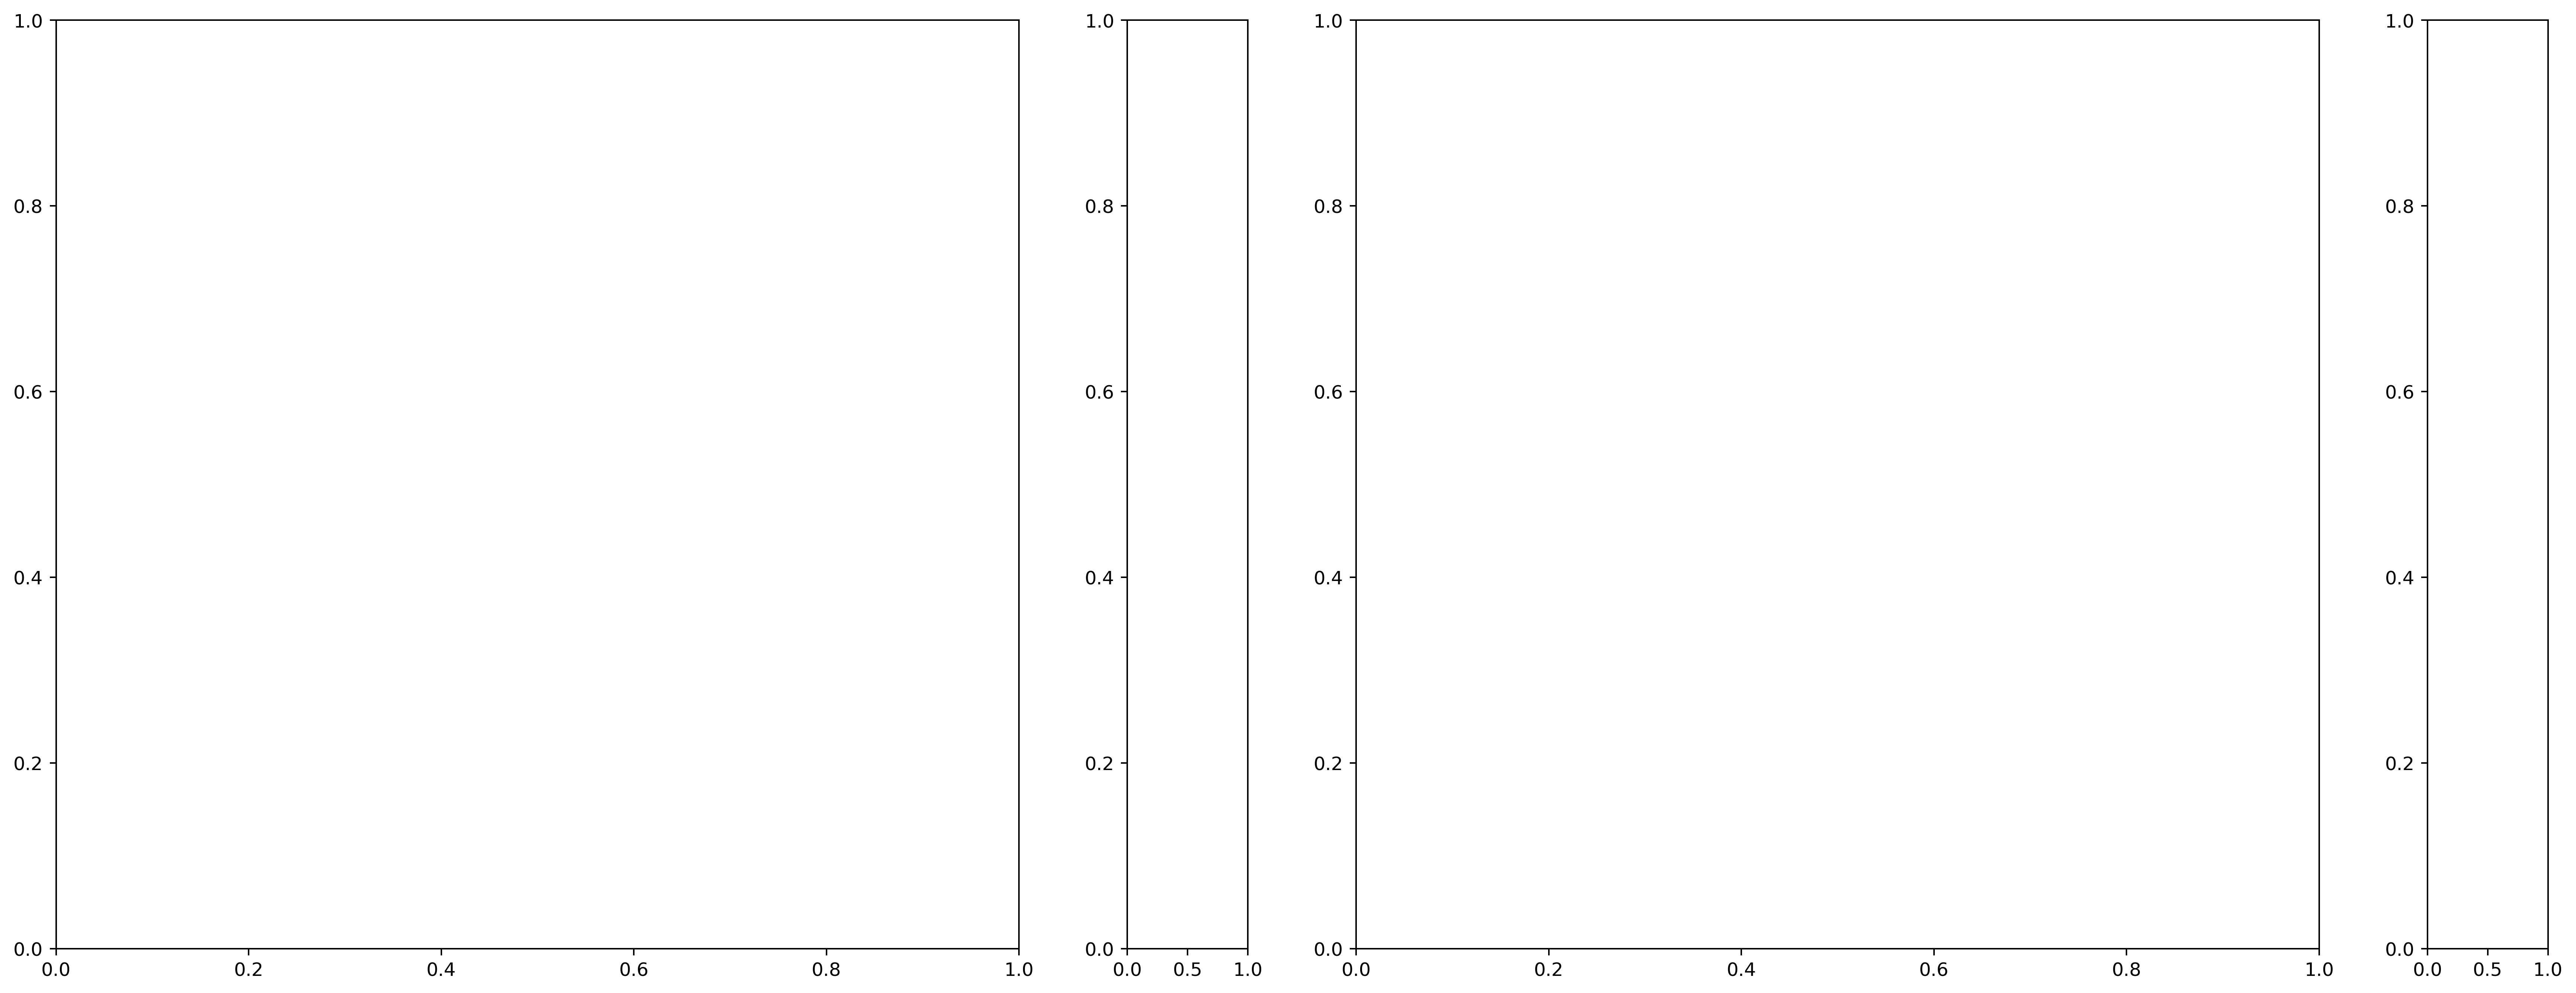

In [70]:
fig, axs = plt.subplots(1, 4, dpi=180, figsize=(12*2, 9*1), gridspec_kw={'width_ratios': [4, 0.5]*2})
axs = axs.flatten()
axs = [(axs[i], axs[i+1]) for i in range(0, len(axs), 2)]
plot('beta_Il2#Egr2', dpi=100, size=20, fig=fig, axes=axs[0])
plot('beta_Il2#Egr2', dpi=100, size=20, fig=fig, axes=axs[1], with_expr=True)
# plot('Egr2', dpi=100, size=20, fig=fig, axes=axs[2])
# plot('Il2', dpi=100, size=20, fig=fig, axes=axs[3])
# plot('beta_Egr2', dpi=100, size=20, fig=fig, axes=axs[4])
# plot('Il2#Egr2', dpi=100, size=20, fig=fig, axes=axs[5])
plt.show()
